In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os

## Load the pretrained model and files

In [2]:
import os
import urllib.request

files_to_download = [
    "signs_model.h5",
    "signs_labels.csv",
    "stop.jpg"
]

current_folder = os.getcwd()

for file_name in files_to_download:
    file_path = os.path.join(current_folder, file_name)

    # Check if file exist
    if not os.path.exists(file_path):
        # Download
        url = f"http://www.kasprowski.pl/datasets/adversarial/{file_name}"
        urllib.request.urlretrieve(url, file_path)
        print(f"Downloaded: {file_name}")
    else:
        print(f"Exist: {file_name}")


Downloaded: signs_model.h5
Downloaded: signs_labels.csv
Downloaded: stop.jpg


In [3]:
model = tf.keras.models.load_model("signs_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_2 (Bat  (None, 64, 64, 16)        64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 32)       

## Load the classes

In [4]:
import pandas as pd
classes = pd.read_csv('signs_labels.csv')
for i in range(20):
    print(f'Label {i}: {classes.loc[i][1]}')

Label 0: Speed limit (20km/h)
Label 1: Speed limit (30km/h)
Label 2: Speed limit (50km/h)
Label 3: Speed limit (60km/h)
Label 4: Speed limit (70km/h)
Label 5: Speed limit (80km/h)
Label 6: End of speed limit (80km/h)
Label 7: Speed limit (100km/h)
Label 8: Speed limit (120km/h)
Label 9: No passing
Label 10: No passing for vehicles over 3.5 metric tons
Label 11: Right-of-way at the next intersection
Label 12: Priority road
Label 13: Yield
Label 14: Stop
Label 15: No vehicles
Label 16: Vehicles over 3.5 metric tons prohibited
Label 17: No entry
Label 18: General caution
Label 19: Dangerous curve to the left


## Predict class for image

1/1 [==============================] - 0s 29ms/step
Image classified as class 14, Stop with probalility 0.9609634280204773


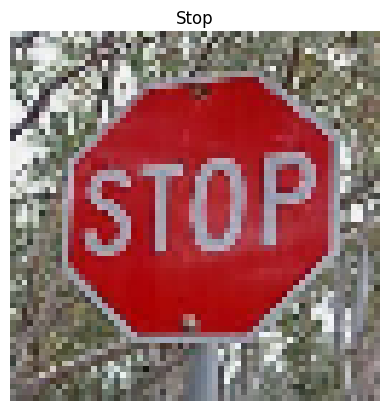

In [6]:
image = cv2.imread("stop.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64,64))
# add one dimension
image2 = np.expand_dims(image, axis=0)
# predict
pred = model.predict(image2)
max = pred[0].argmax()
plt.imshow(image)
plt.title(classes.loc[max][1])
plt.axis("off")
print(f'Image classified as class {max}, {classes.loc[max][1]} with probalility {pred[0][max]}')

Task part

In [15]:
# import necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [14]:
optimizer = Adam(learning_rate=0.01)
lossFunct = SparseCategoricalCrossentropy()
steps = 100
target_class = 12
baseImage = image2
baseImage = tf.constant(image2, dtype=tf.float32)

1/1 [==============================] - 0s 20ms/step
Predicted class:  14 Stop Stop


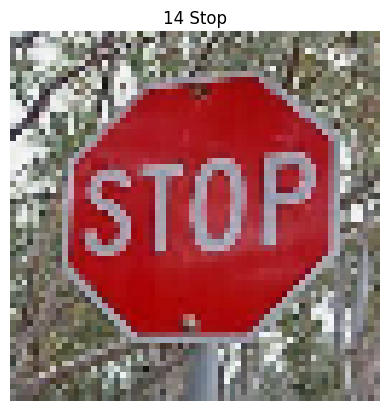

In [16]:
org_pred = model.predict(image2)
dec_pred = classes.loc[pred[0].argmax()][1]
real_class = org_pred.argmax()
real_label = dec_pred
real_pred = dec_pred
print("Predicted class: ",real_class,real_label,real_pred)
plt.imshow(image)
plt.title(f"{real_class} {real_label}")
plt.axis("off")
plt.show()

In [63]:
def do_step(image,delta,real_class):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        adversary = (baseImage + delta)
        predictions = model(adversary, training=False)

        # originalLoss = lossFunct(tf.convert_to_tensor([real_class]),predictions)
        # loss = - originalLoss

        originalLoss = lossFunct(tf.convert_to_tensor([real_class]),predictions)
        targetLoss = lossFunct(tf.convert_to_tensor([target_class]),predictions)
        loss = targetLoss - originalLoss  # goal: minimize error to targetLoss and maximize error to originalLoss


    gradients = tape.gradient(loss, delta)

    # optimizer.apply_gradients([(gradients, delta)])
    # delta.assign_add(delta)

    optimizer.apply_gradients([(gradients, delta)])
    clipped_delta = tf.clip_by_value(delta, clip_value_min=-0.01, clip_value_max=0.01)
    delta.assign_add(clipped_delta)

    # Stop
    if np.array(predictions[0]).argmax() == target_class:
      stop_value = -1
      if predictions[0,np.array(predictions[0]).argmax()] > 0.8:
        stop_value = np.array(predictions[0]).argmax() * predictions[0,np.array(predictions[0]).argmax()]
    else:
      stop_value = -1

    return delta,loss, stop_value

In [59]:
def show_step(delta,loss):
    print("step: {}, loss: {}...".format(step, loss.numpy()))
    adverImage = (baseImage + delta).numpy().squeeze()
    adverImage = np.clip(adverImage, 0, 255).astype("uint8")
    adverImage = np.expand_dims(adverImage, axis=0)
    predictions = model.predict(adverImage)
    top3 = classes.loc[predictions[0].argmax()][1]
    # print("{}. {} -> ({}:{:.2f})".format(step,real_label,
    #             top3))
    print(top3)

    fig=plt.figure(figsize=(12,8))
    ax = plt.subplot(1, 3, 1)
    plt.title(f"Original {real_label}")
    plt.imshow(image.squeeze())
    plt.axis("off")
    ax = plt.subplot(1, 3, 2)
    plt.title("Delta")
    plt.imshow(np.clip((delta.numpy().squeeze()*256).astype("uint8"), 0, 255))
    plt.xlabel(f"target class: {target_class}")
    ax = plt.subplot(1, 3, 3)
    plt.title(f"Adversary: {top3}")
    plt.xlabel(f"class no: {predictions[0].argmax()}, {predictions[0][predictions[0].argmax()]*100}%")
    plt.imshow(adverImage.squeeze())
    # plt.axis("off")
    plt.show()
    # cv2.imwrite(f"outdir/{image_name}_{step:02d}.jpg", cv2.cvtColor(adverImage.squeeze(), cv2.COLOR_RGB2BGR))


## Adversarial attacks

step: 0, loss: 41.862701416015625...
1/1 [==============================] - 0s 18ms/step
Stop


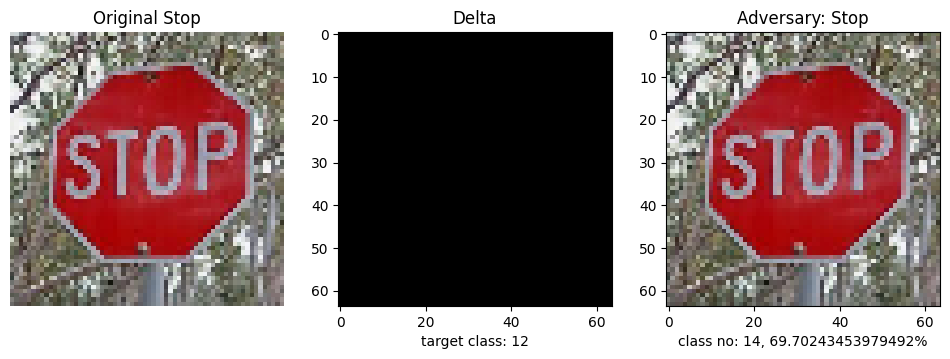

step: 100, loss: 32.93692398071289...
1/1 [==============================] - 0s 27ms/step
No entry


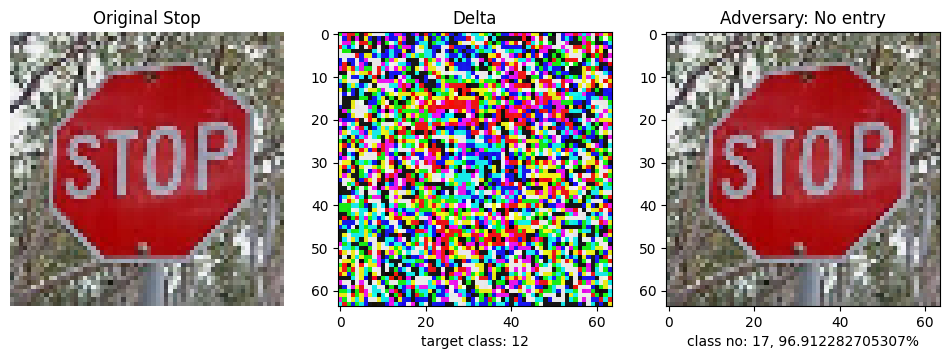

step: 200, loss: 24.902332305908203...
1/1 [==============================] - 0s 18ms/step
No entry


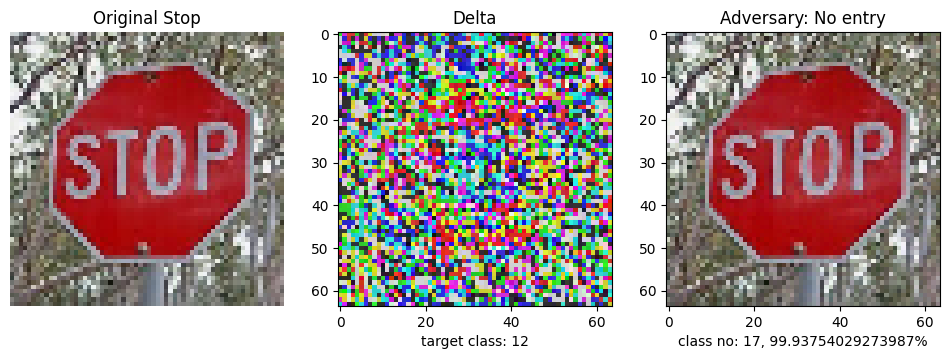

step: 300, loss: 17.565902709960938...
1/1 [==============================] - 0s 20ms/step
No entry


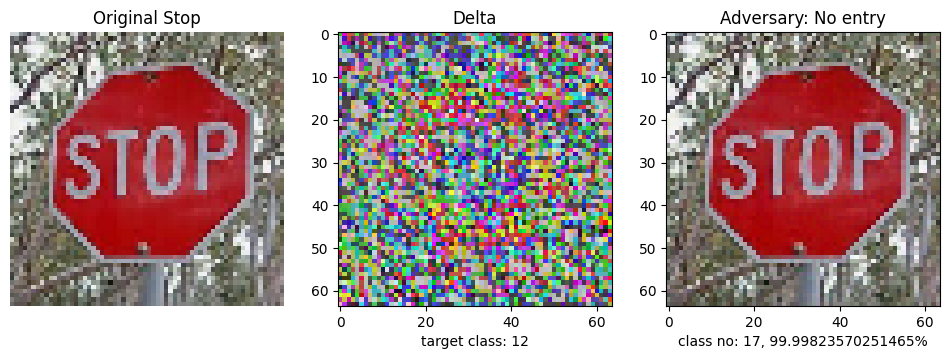

step: 400, loss: 11.113547325134277...
1/1 [==============================] - 0s 24ms/step
No entry


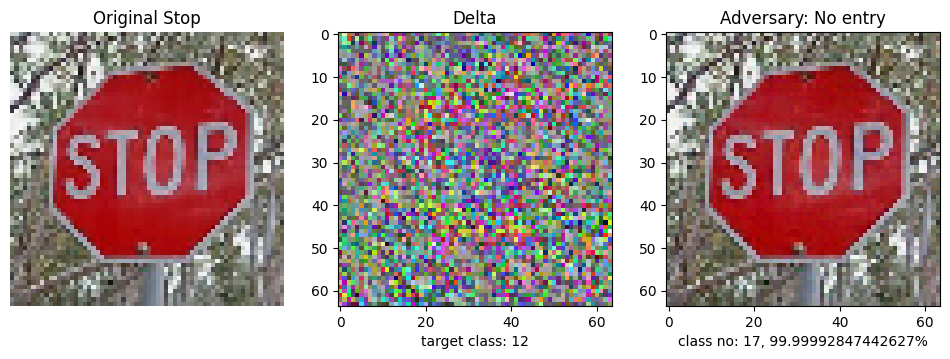

step: 500, loss: 5.202922821044922...
1/1 [==============================] - 0s 23ms/step
No entry


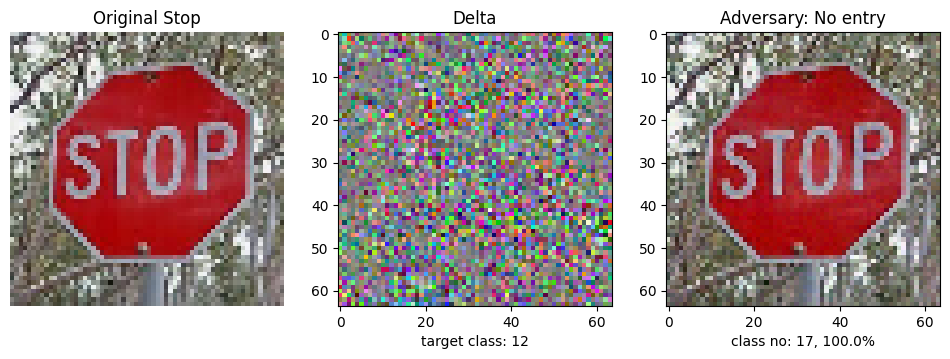

step: 600, loss: -0.3489265441894531...
1/1 [==============================] - 0s 38ms/step
No entry


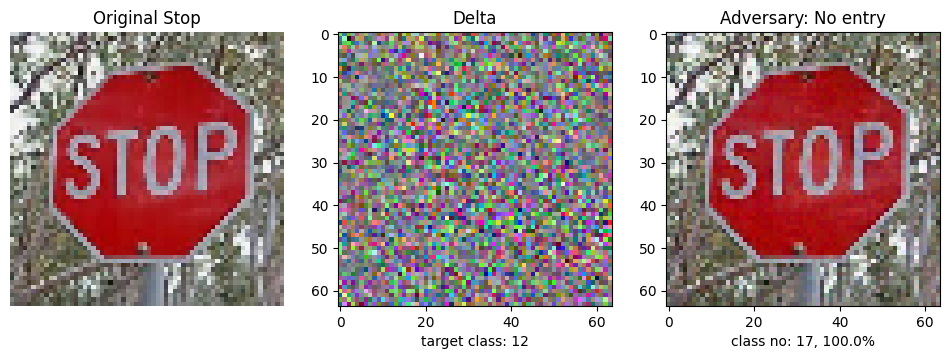

step: 700, loss: -5.594827651977539...
1/1 [==============================] - 0s 22ms/step
No entry


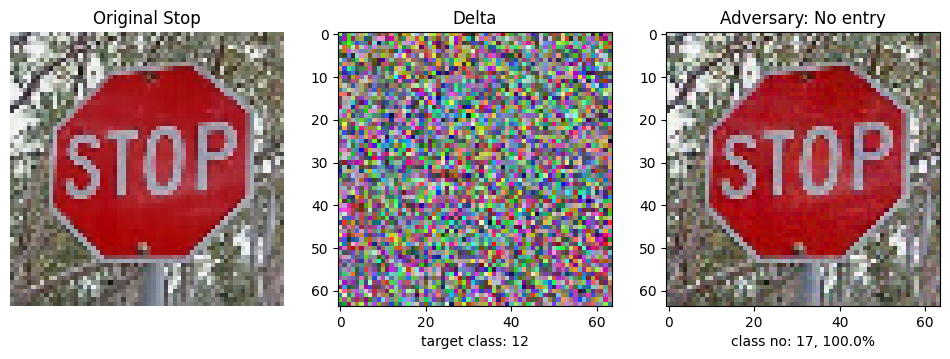

step: 800, loss: -10.616458892822266...
1/1 [==============================] - 0s 21ms/step
No entry


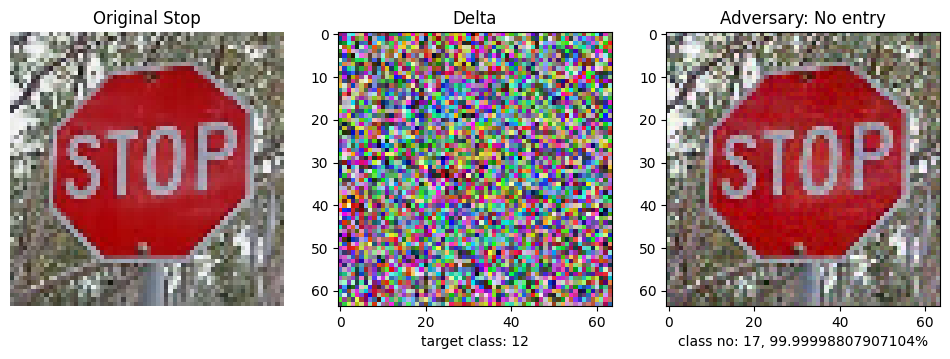

step: 900, loss: -15.3410005569458...
1/1 [==============================] - 0s 21ms/step
No entry


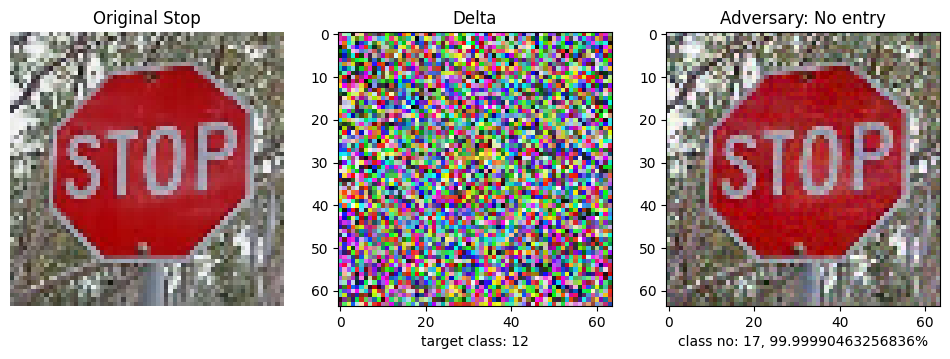

step: 1000, loss: -19.849117279052734...
1/1 [==============================] - 0s 28ms/step
No entry


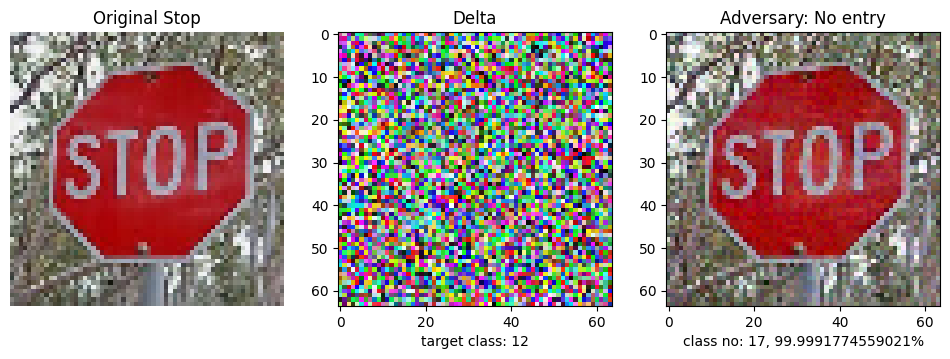

step: 1100, loss: -24.140621185302734...
1/1 [==============================] - 0s 20ms/step
No entry


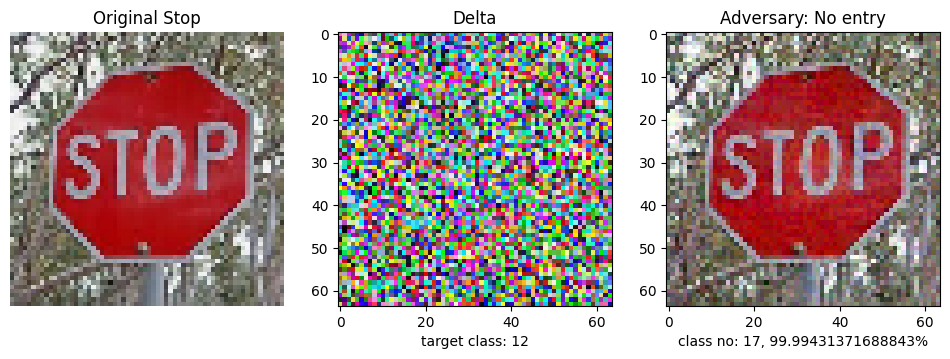

step: 1200, loss: -28.235349655151367...
1/1 [==============================] - 0s 24ms/step
No entry


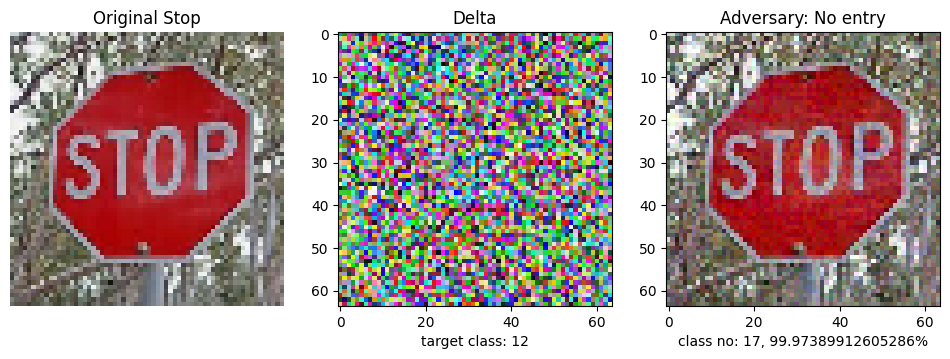

step: 1300, loss: -32.20242691040039...
1/1 [==============================] - 0s 20ms/step
No entry


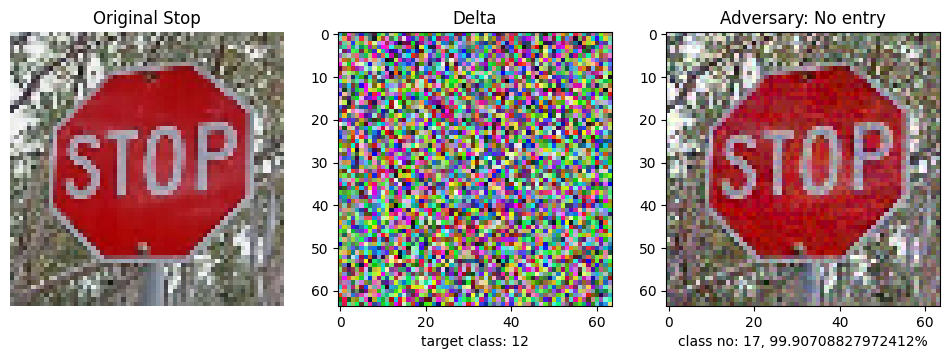

step: 1400, loss: -36.00978088378906...
1/1 [==============================] - 0s 21ms/step
No entry


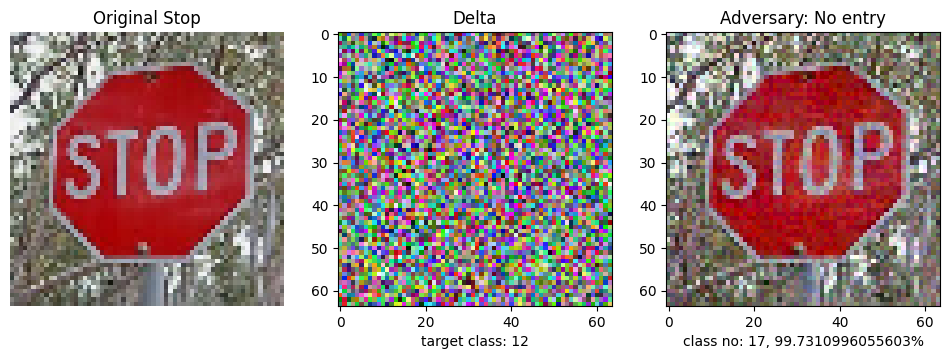

step: 1500, loss: -39.68631362915039...
1/1 [==============================] - 0s 30ms/step
No entry


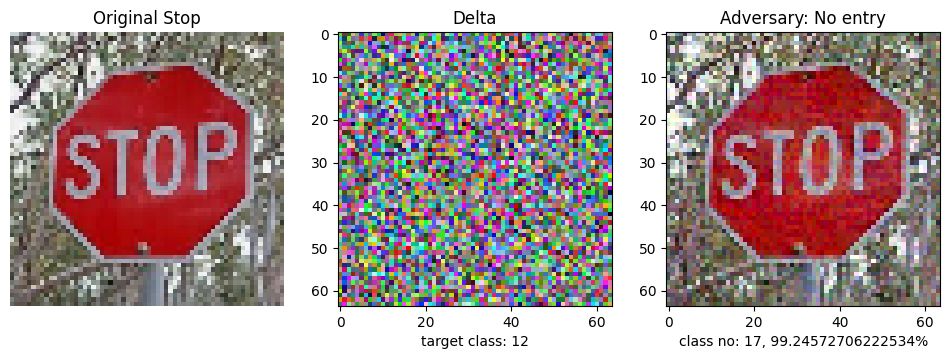

step: 1600, loss: -43.26333236694336...
1/1 [==============================] - 0s 21ms/step
No entry


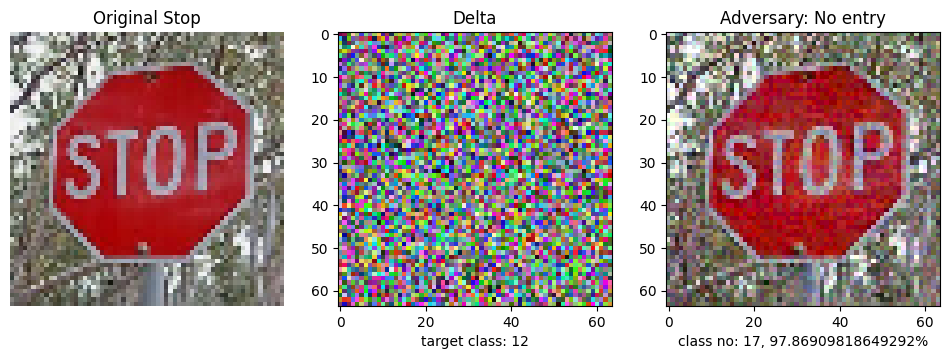

step: 1700, loss: -46.74283218383789...
1/1 [==============================] - 0s 20ms/step
No entry


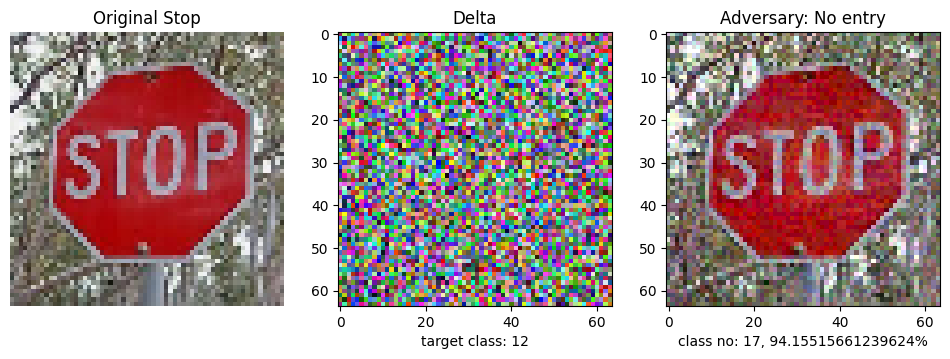

step: 1800, loss: -50.10948181152344...
1/1 [==============================] - 0s 24ms/step
No entry


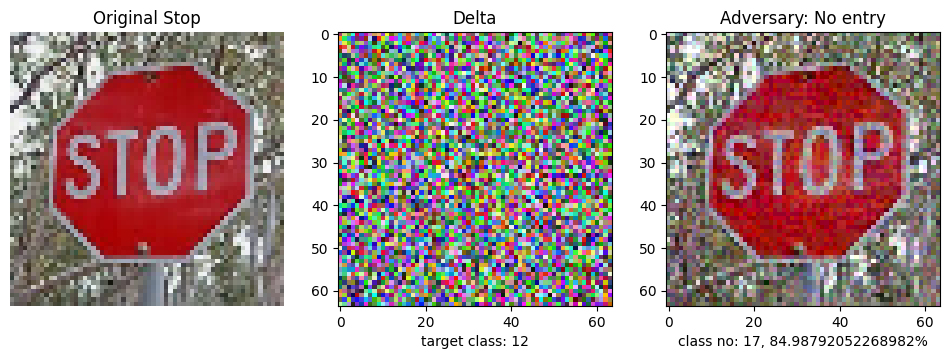

step: 1900, loss: -53.380218505859375...
1/1 [==============================] - 0s 33ms/step
No entry


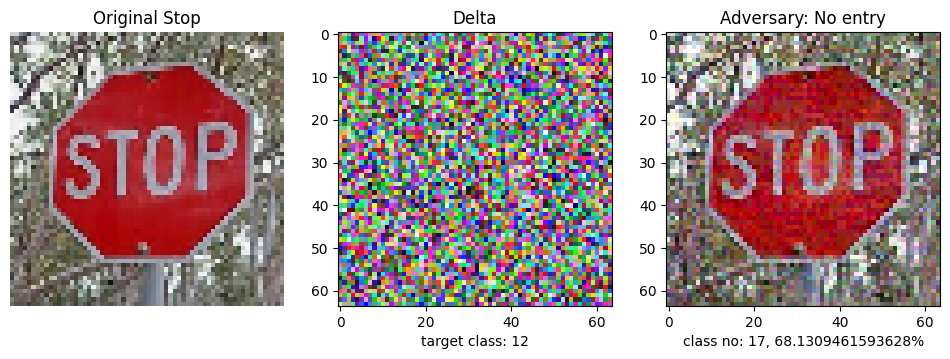

step: 2000, loss: -56.39722442626953...
1/1 [==============================] - 0s 22ms/step
Priority road


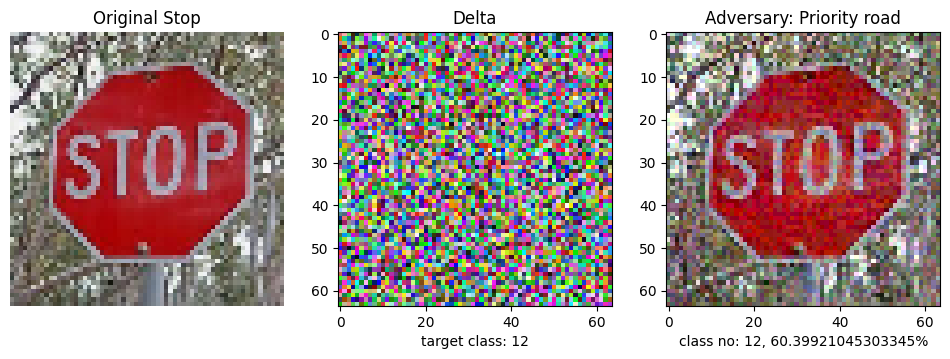

step: 2100, loss: -59.3624267578125...
1/1 [==============================] - 0s 22ms/step
Priority road


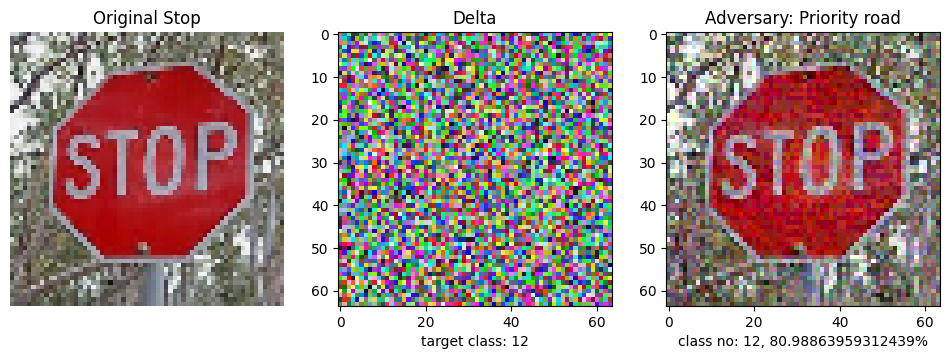

step: 2200, loss: -62.24000549316406...
1/1 [==============================] - 0s 21ms/step
Priority road


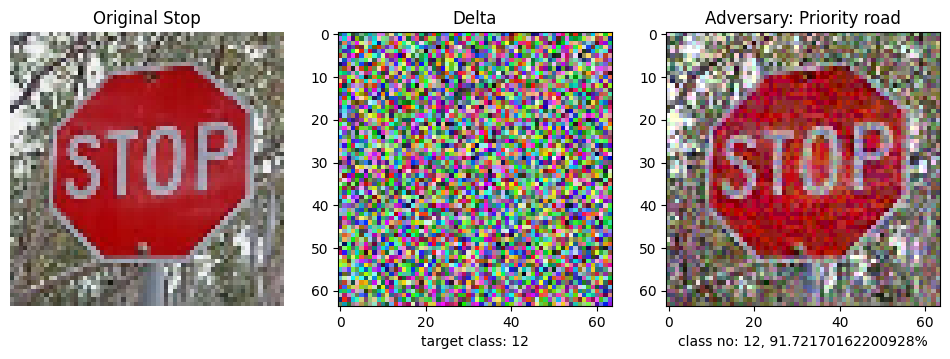

step: 2300, loss: -65.02975463867188...
1/1 [==============================] - 0s 30ms/step
Priority road


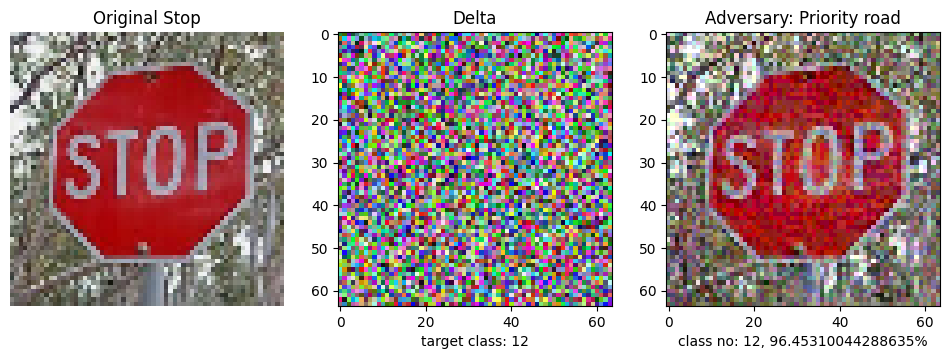

step: 2400, loss: -67.76812744140625...
1/1 [==============================] - 0s 21ms/step
Priority road


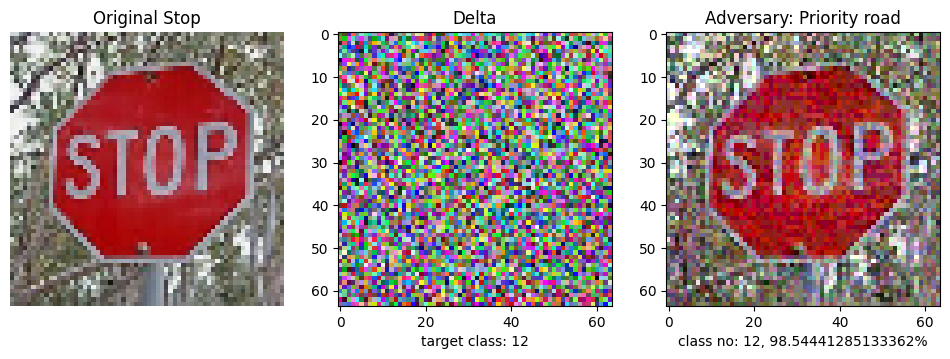

step: 2500, loss: -70.48125457763672...
1/1 [==============================] - 0s 21ms/step
Priority road


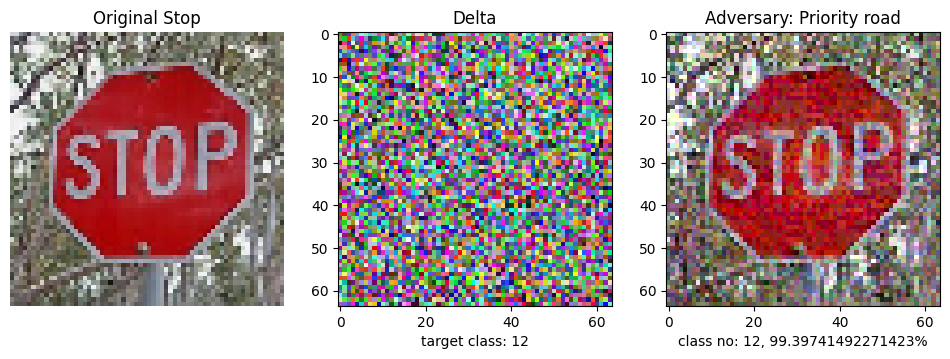

step: 2600, loss: -73.11407470703125...
1/1 [==============================] - 0s 20ms/step
Priority road


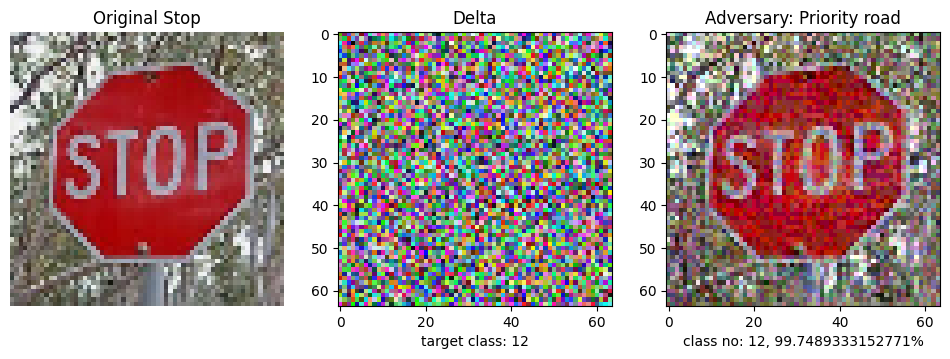

step: 2700, loss: -75.73094177246094...
1/1 [==============================] - 0s 28ms/step
Priority road


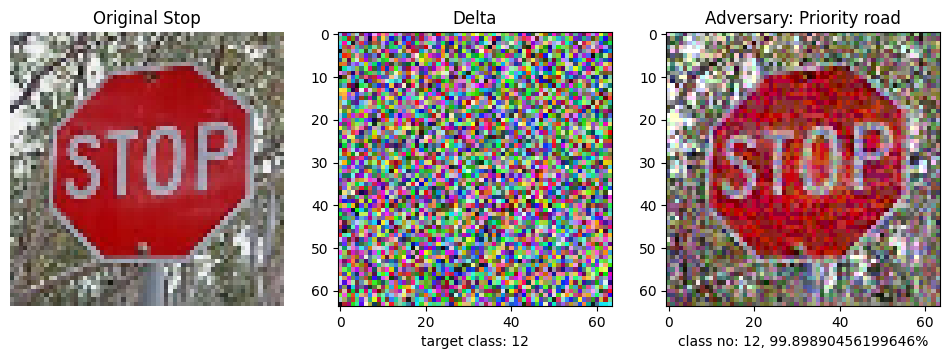

step: 2800, loss: -78.3155746459961...
1/1 [==============================] - 0s 20ms/step
Priority road


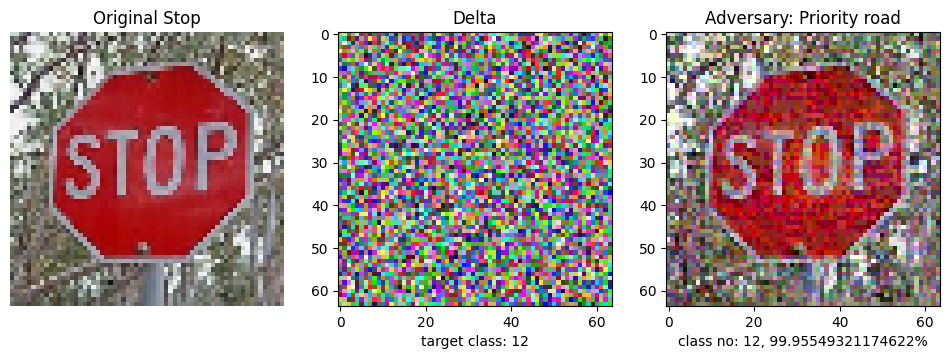

step: 2900, loss: -80.85321044921875...
1/1 [==============================] - 0s 20ms/step
Priority road


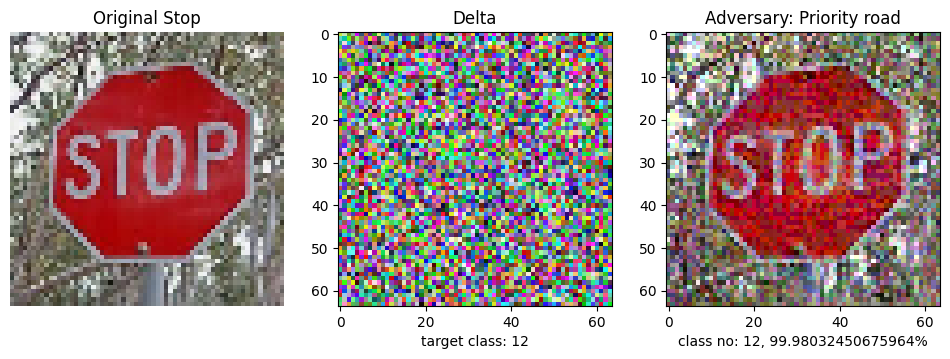

step: 3000, loss: -83.3546142578125...
1/1 [==============================] - 0s 20ms/step
Priority road


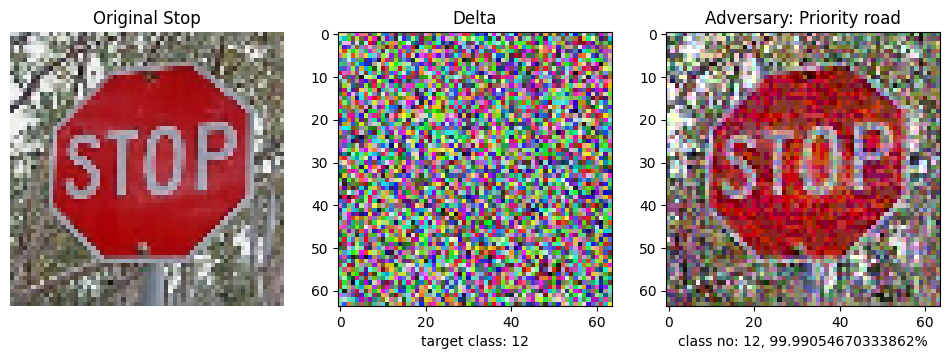

step: 3100, loss: -85.8496322631836...
1/1 [==============================] - 0s 35ms/step
Priority road


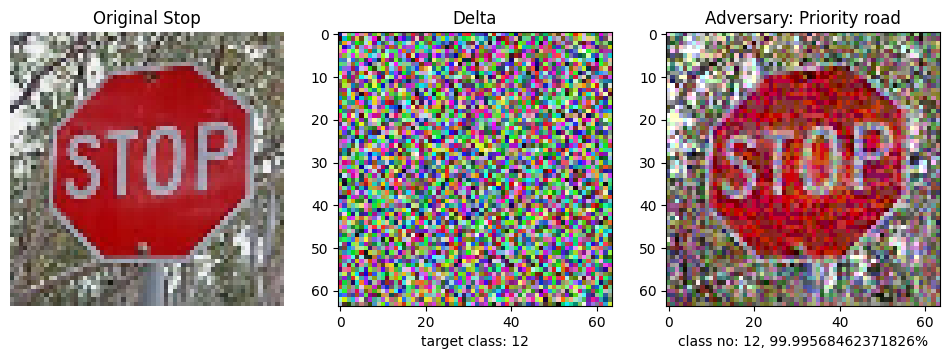

step: 3200, loss: -88.34827423095703...
1/1 [==============================] - 0s 21ms/step
Priority road


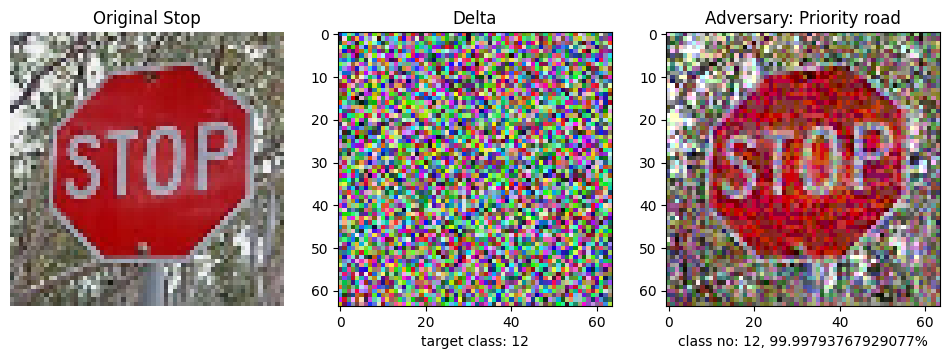

step: 3300, loss: -90.80140686035156...
1/1 [==============================] - 0s 23ms/step
Priority road


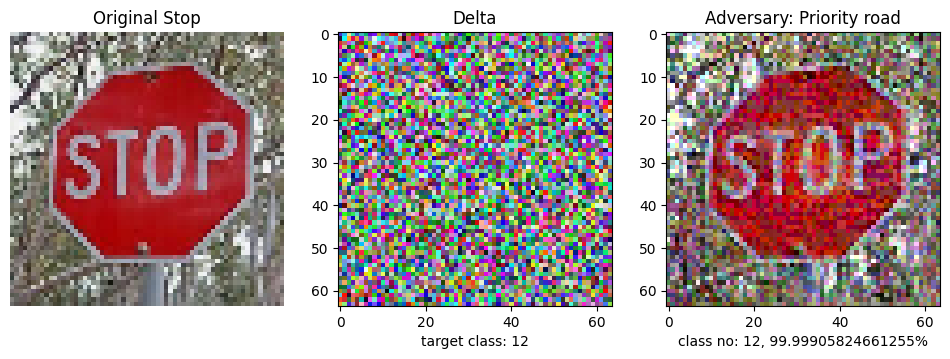

step: 3400, loss: -93.22394561767578...
1/1 [==============================] - 0s 23ms/step
Priority road


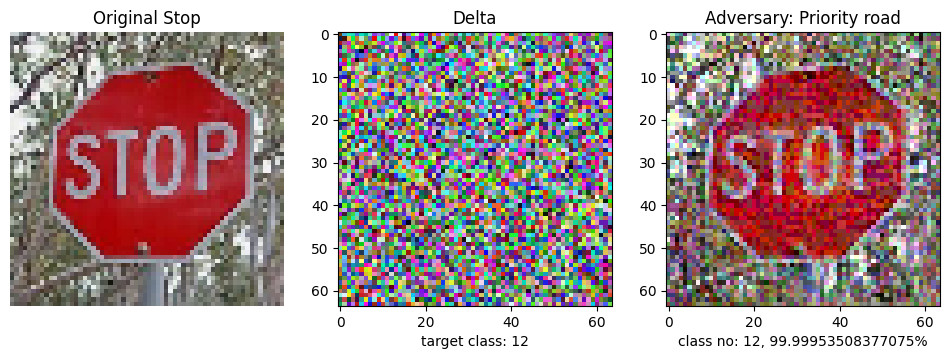

step: 3500, loss: -95.62979888916016...
1/1 [==============================] - 0s 31ms/step
Priority road


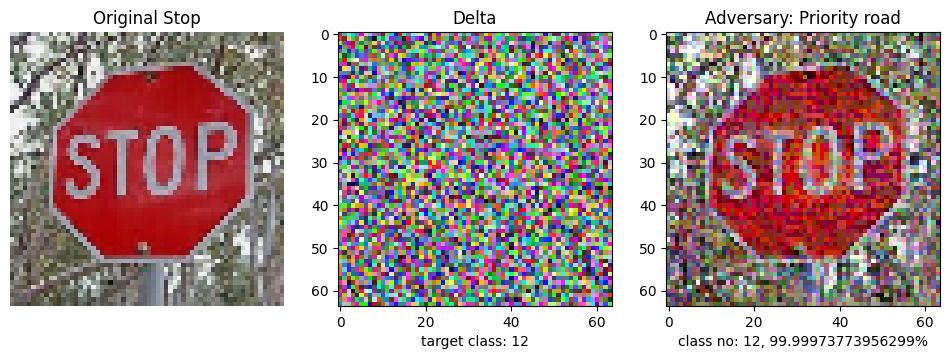

step: 3600, loss: -98.03092956542969...
1/1 [==============================] - 0s 22ms/step
Priority road


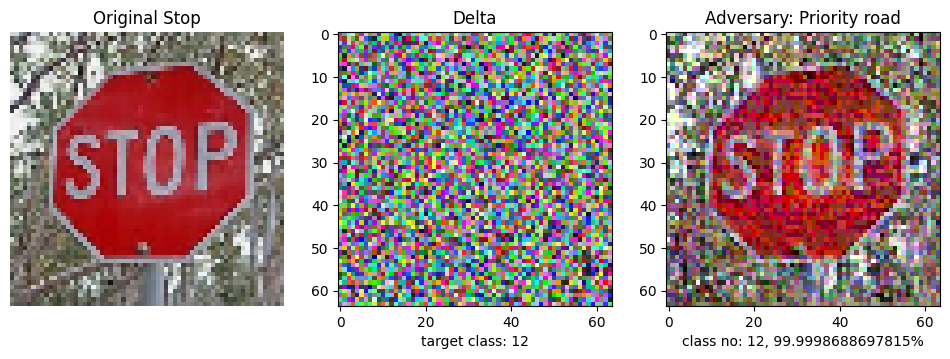

step: 3700, loss: -100.42845916748047...
1/1 [==============================] - 0s 23ms/step
Priority road


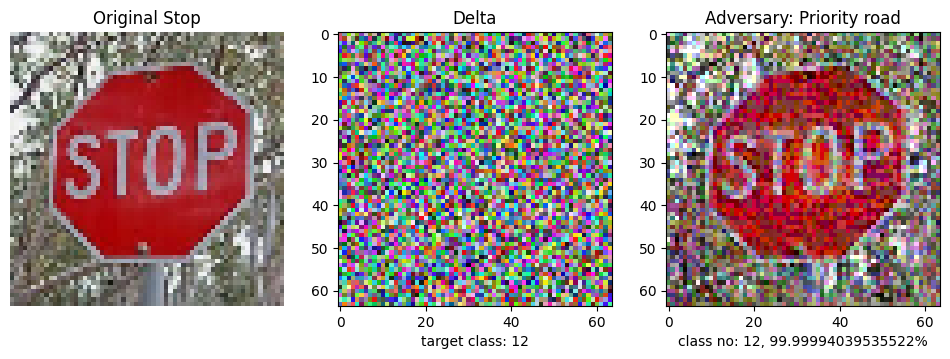

step: 3800, loss: -102.78366088867188...
1/1 [==============================] - 0s 21ms/step
Priority road


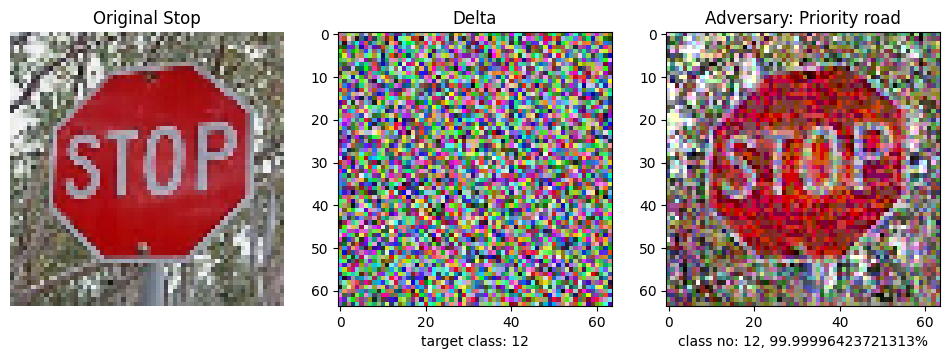

step: 3900, loss: -105.11589050292969...
1/1 [==============================] - 0s 28ms/step
Priority road


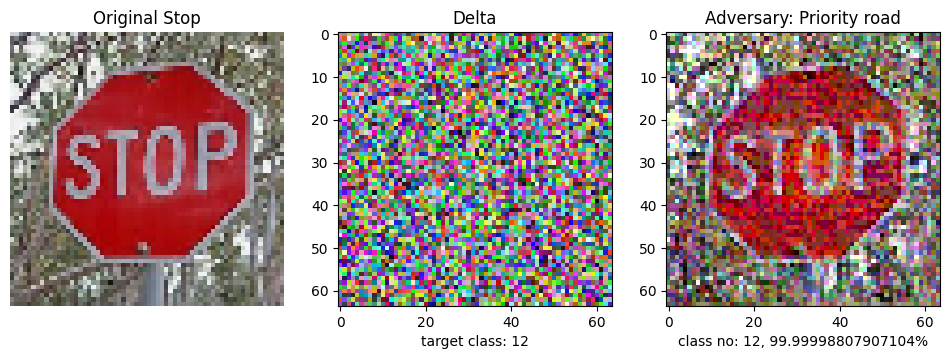

step: 4000, loss: -107.458251953125...
1/1 [==============================] - 0s 21ms/step
Priority road


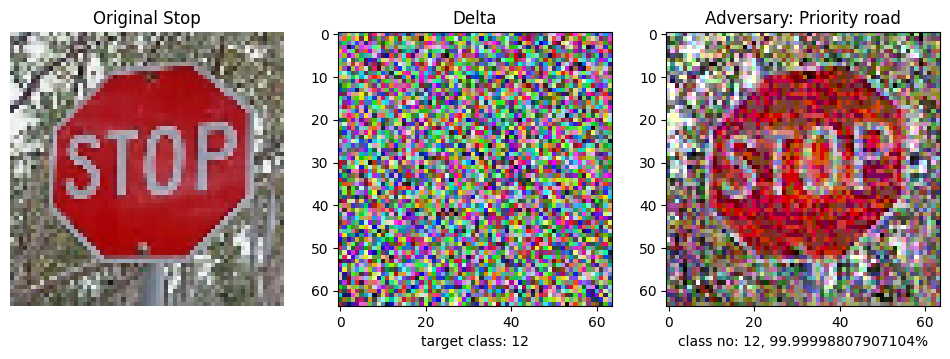

step: 4021, loss: -107.95233154296875...
1/1 [==============================] - 0s 20ms/step
Priority road


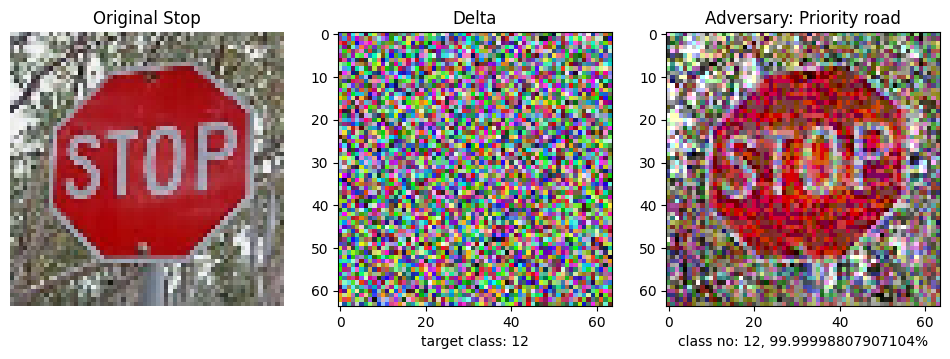

Done


In [64]:
steps = 10000

optimizer = Adam(learning_rate=0.001)
lossFunct = SparseCategoricalCrossentropy()

target_class = 12
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

# loop stops, when model predict class 12 - prority road
# grad.clipping from -0.01 to 0.01 to find best visual quality for human eye
# and model prediction equal 100%
for step in range(0, steps):
    delta,loss,stop_value = do_step(baseImage, delta, real_class)
    if stop_value == target_class:
      show_step(delta,loss)
      break
    if step % 100==0:
        show_step(delta,loss)
print("Done")

## Test adversiall Attack for all classes, basing on distortion stop sign Interrupted keyboard at 1h30 run, 31 class

step: 1576, loss: -19.09197998046875...
1/1 [==============================] - 0s 20ms/step
Speed limit (20km/h)


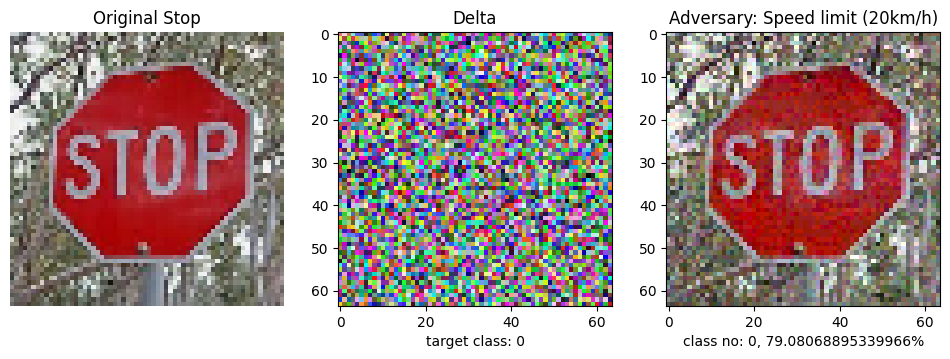

step: 2956, loss: -74.378173828125...
1/1 [==============================] - 0s 22ms/step
Speed limit (30km/h)


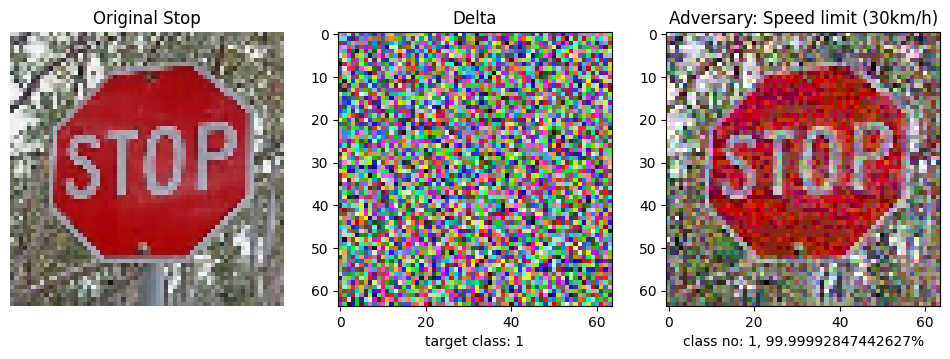

step: 1224, loss: -29.400772094726562...
1/1 [==============================] - 0s 19ms/step
Speed limit (50km/h)


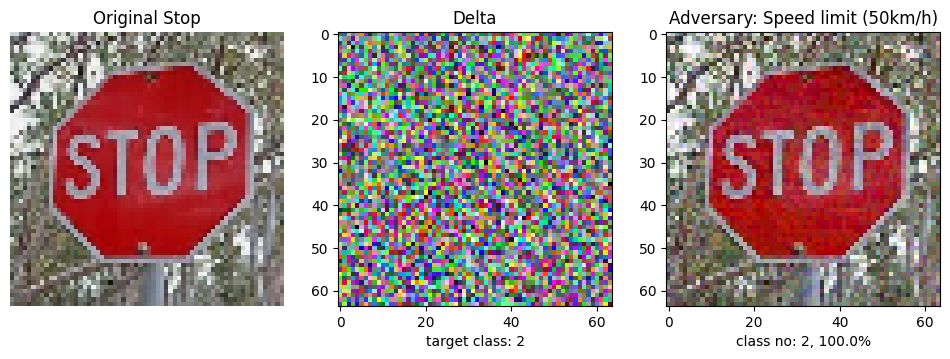

step: 2372, loss: -52.052024841308594...
1/1 [==============================] - 0s 21ms/step
Speed limit (60km/h)


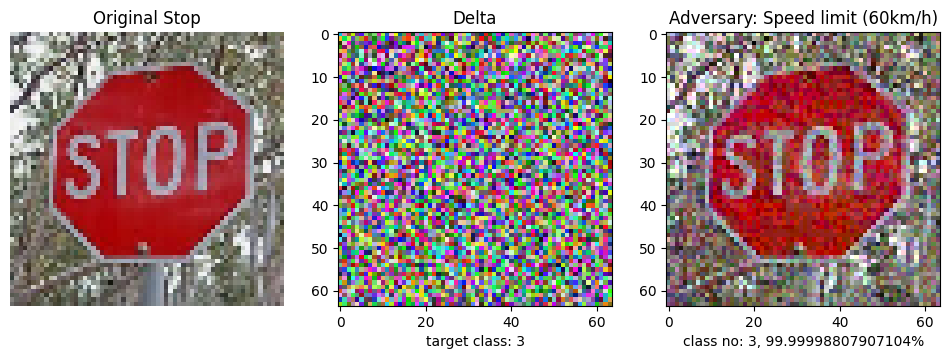

step: 2052, loss: -45.37117004394531...
1/1 [==============================] - 0s 21ms/step
Speed limit (70km/h)


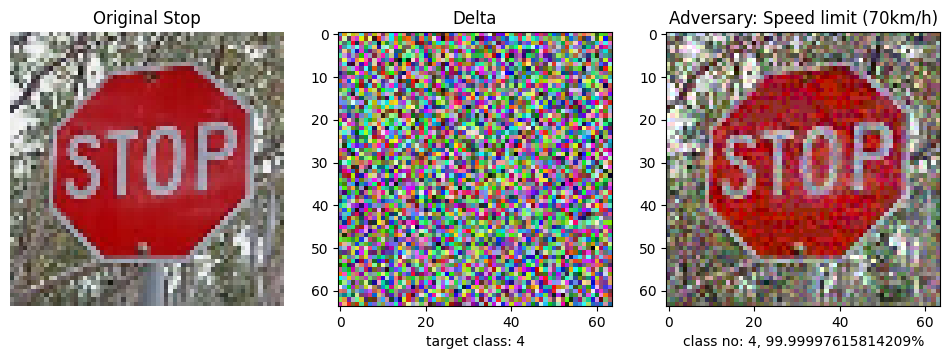

step: 2046, loss: -44.448326110839844...
1/1 [==============================] - 0s 23ms/step
Speed limit (80km/h)


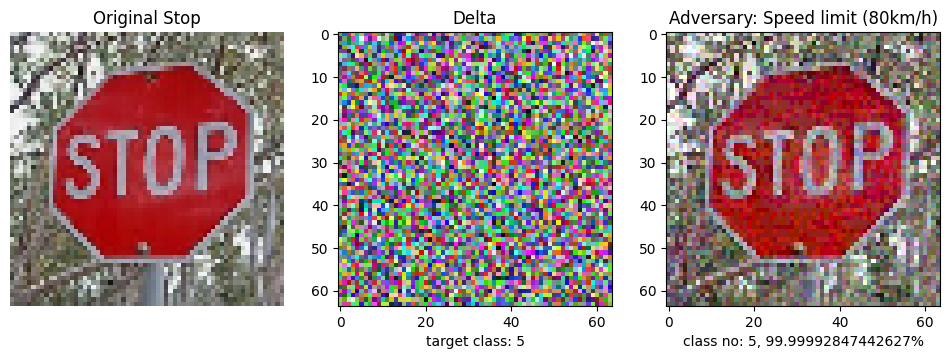

step: 8109, loss: -119.84765625...
1/1 [==============================] - 0s 20ms/step
End of speed limit (80km/h)


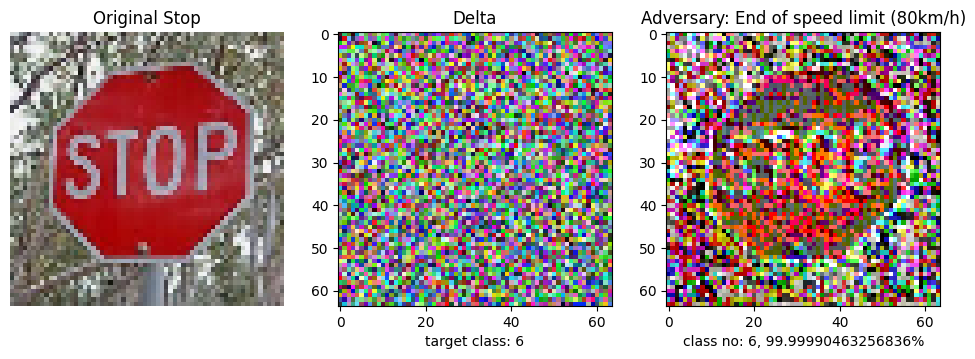

step: 4992, loss: -101.54656219482422...
1/1 [==============================] - 0s 23ms/step
Speed limit (100km/h)


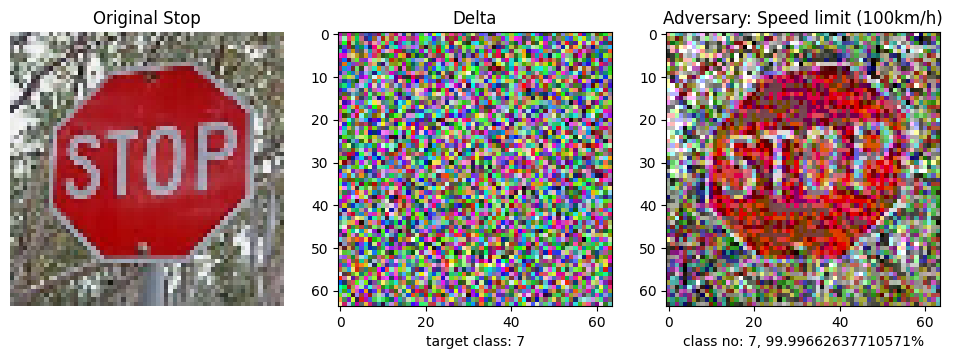

step: 4614, loss: -92.0840835571289...
1/1 [==============================] - 0s 20ms/step
Speed limit (120km/h)


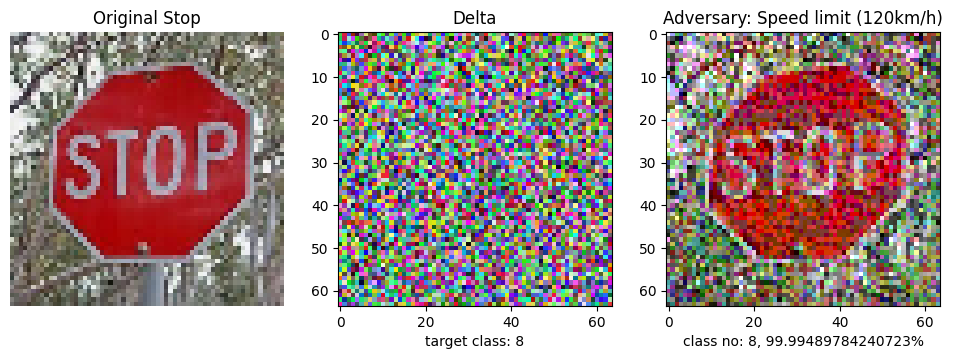

step: 1167, loss: -42.347564697265625...
1/1 [==============================] - 0s 19ms/step
No passing


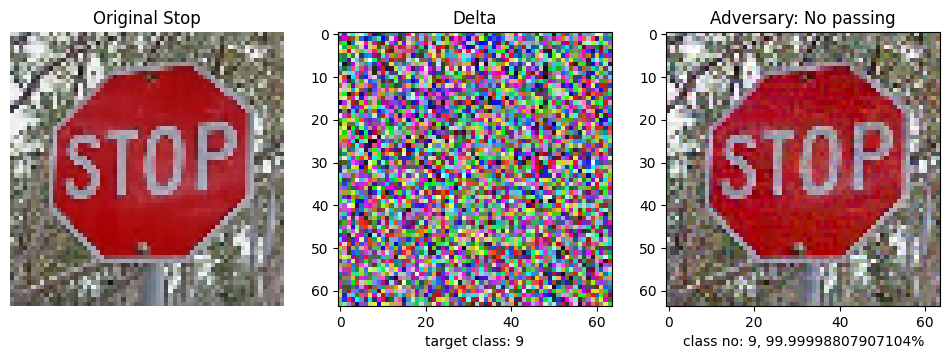

step: 1213, loss: -39.28438186645508...
1/1 [==============================] - 0s 29ms/step
No passing for vehicles over 3.5 metric tons


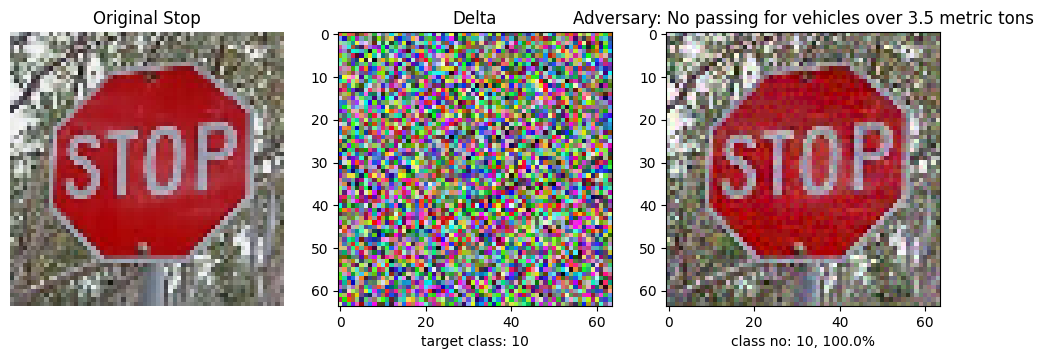

step: 3282, loss: -74.22086334228516...
1/1 [==============================] - 0s 20ms/step
Right-of-way at the next intersection


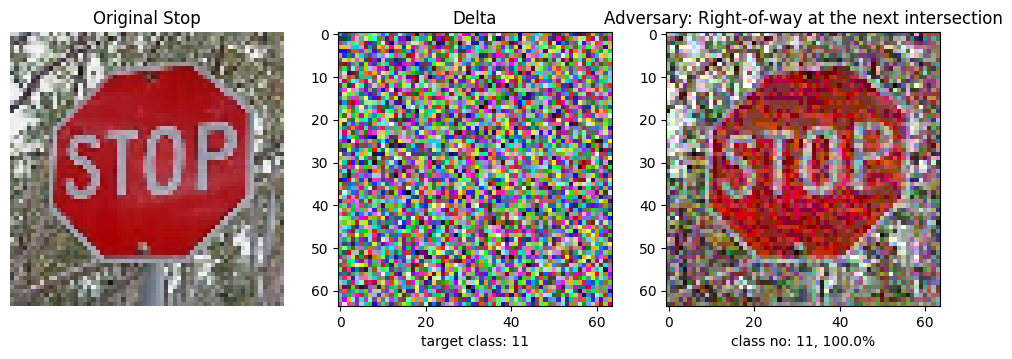

step: 4021, loss: -107.95232391357422...
1/1 [==============================] - 0s 20ms/step
Priority road


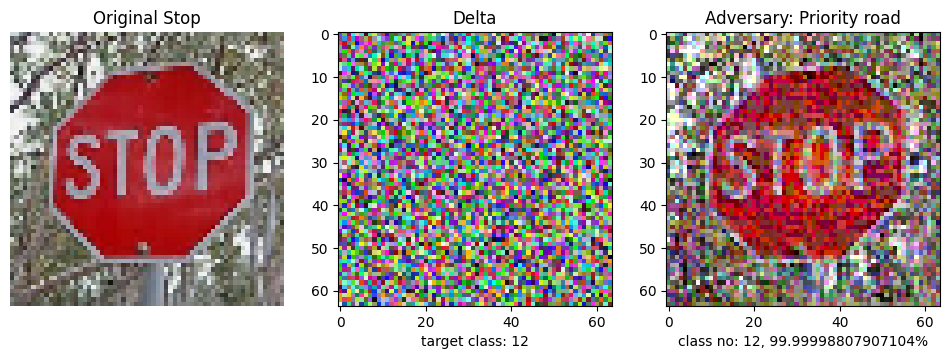

step: 1358, loss: -32.575260162353516...
1/1 [==============================] - 0s 22ms/step
Yield


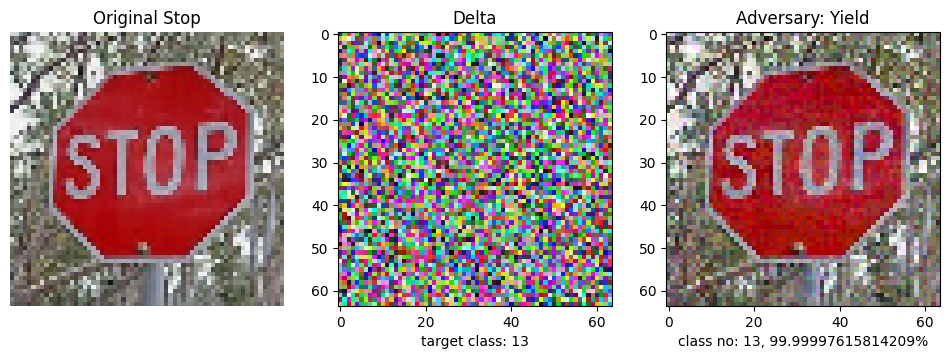

step: 820, loss: -21.554595947265625...
1/1 [==============================] - 0s 30ms/step
No vehicles


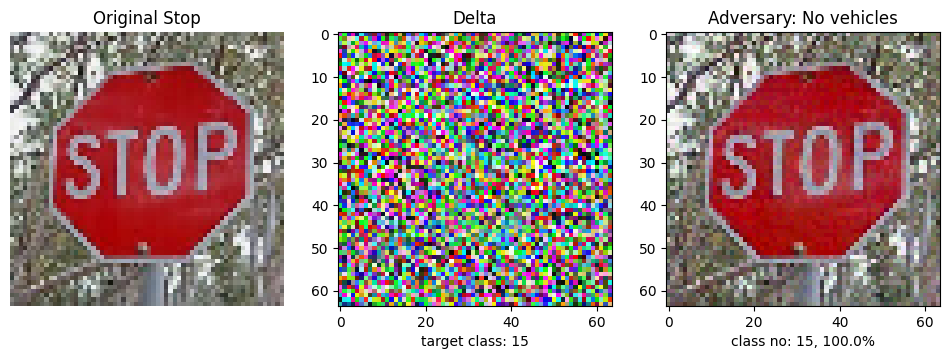

step: 3550, loss: -68.45909118652344...
1/1 [==============================] - 0s 35ms/step
Vehicles over 3.5 metric tons prohibited


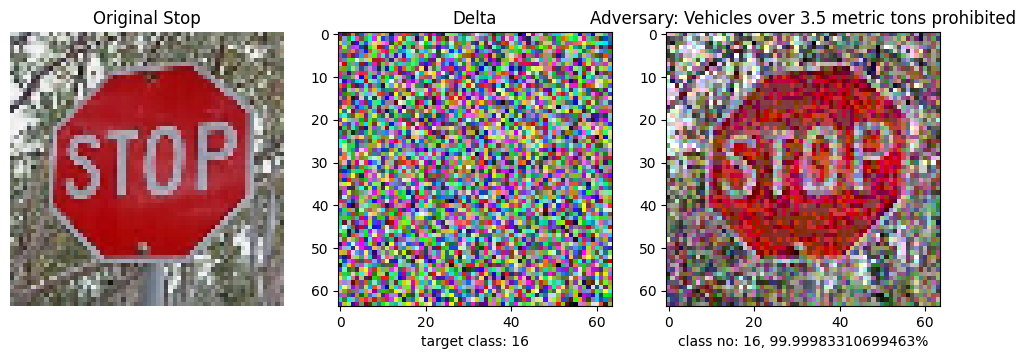

step: 235, loss: -16.657546997070312...
1/1 [==============================] - 0s 19ms/step
No entry


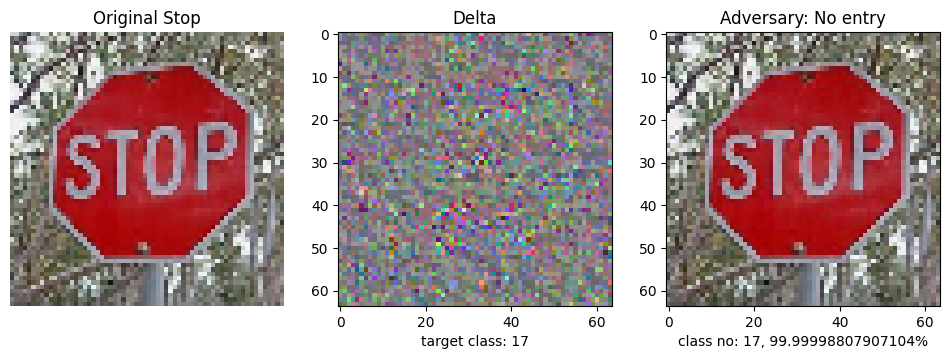

step: 2210, loss: -28.210769653320312...
1/1 [==============================] - 0s 22ms/step
General caution


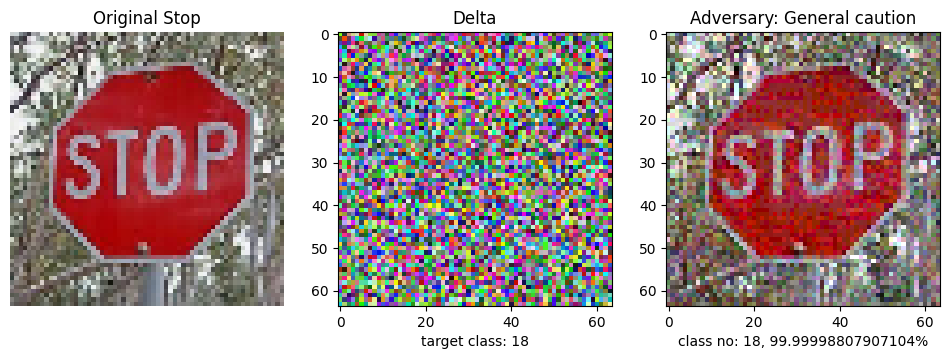

step: 3080, loss: -54.67896270751953...
1/1 [==============================] - 0s 20ms/step
Double curve


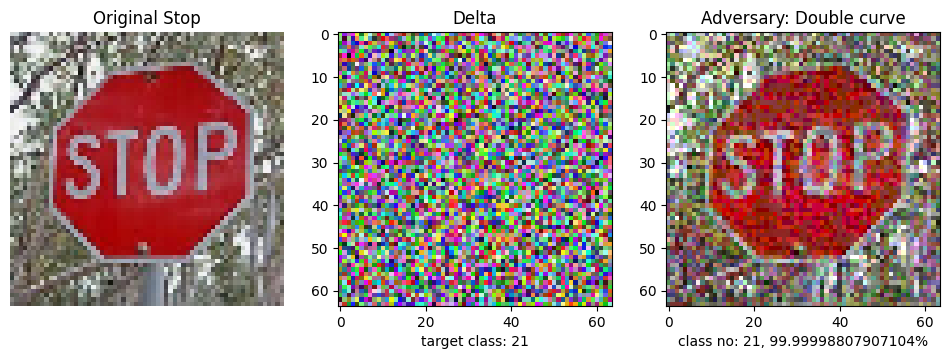

step: 9654, loss: -148.40447998046875...
1/1 [==============================] - 0s 20ms/step
Bumpy road


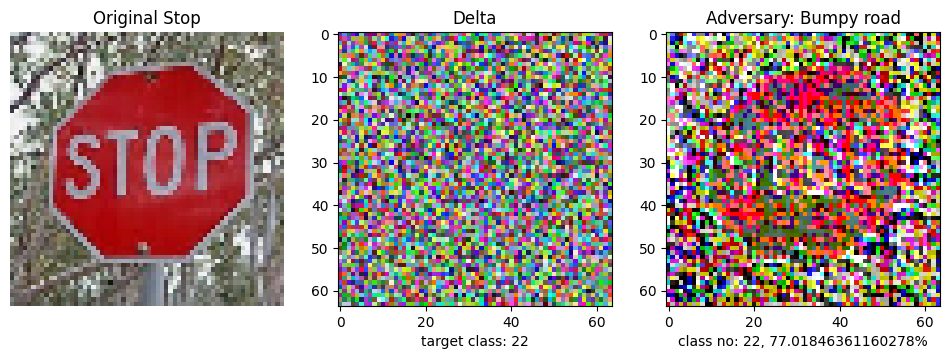

step: 4350, loss: -102.10965728759766...
1/1 [==============================] - 0s 20ms/step
Slippery road


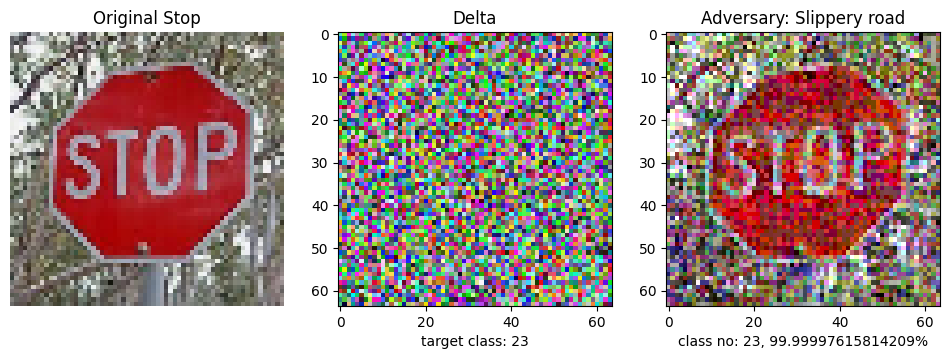

step: 1752, loss: -37.629512786865234...
1/1 [==============================] - 0s 19ms/step
Road work


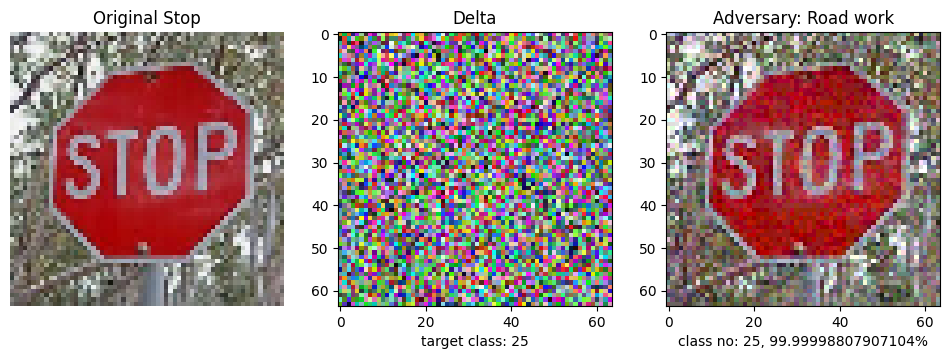

step: 3568, loss: -72.12784576416016...
1/1 [==============================] - 0s 29ms/step
Traffic signals


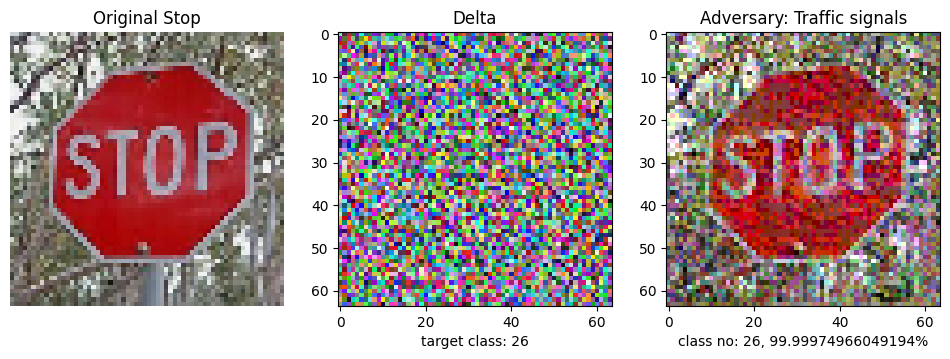

step: 8994, loss: -123.67298889160156...
1/1 [==============================] - 0s 19ms/step
Children crossing


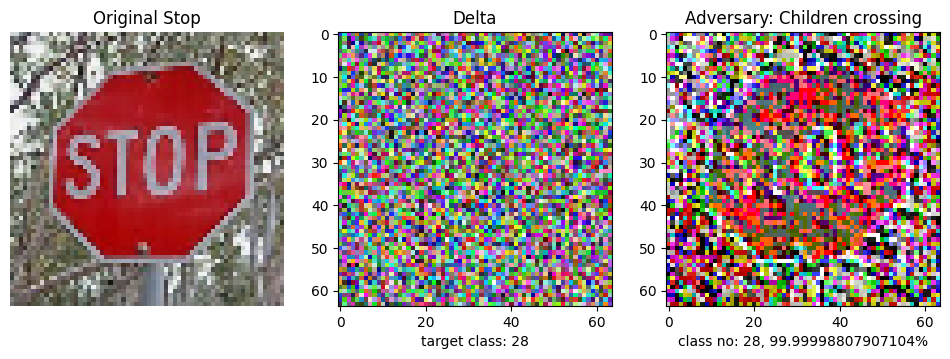

step: 1705, loss: -44.31549835205078...
1/1 [==============================] - 0s 19ms/step
Bicycles crossing


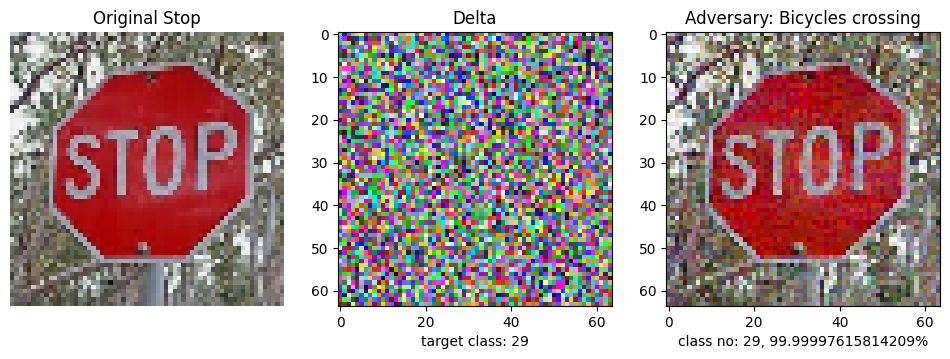

step: 5450, loss: -86.76885223388672...
1/1 [==============================] - 0s 19ms/step
Wild animals crossing


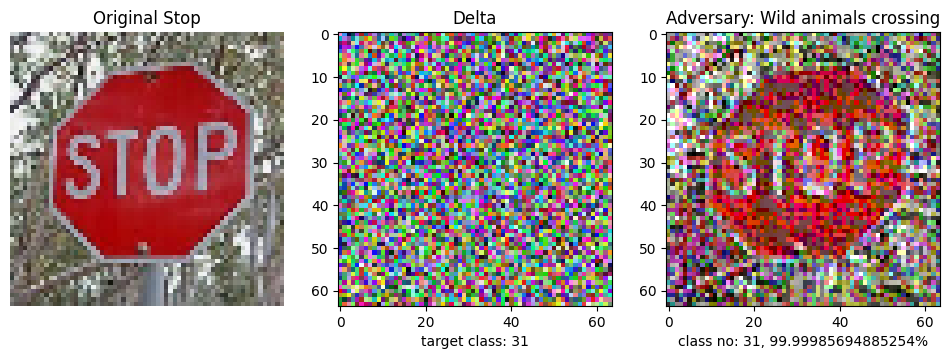

KeyboardInterrupt: 

In [60]:
steps = 10000


# loop stops, when model predict class 12 - prority road
# grad.clipping from -0.01 to 0.01 to find best visual quality for human eye
# and model prediction equal 100%
for target_class in range(len(classes)):
  optimizer = Adam(learning_rate=0.001)
  lossFunct = SparseCategoricalCrossentropy()
  delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
  for step in range(0, steps):
    delta,loss,stop_value = do_step(baseImage, delta, real_class)
    if stop_value == target_class:
      show_step(delta,loss)
      break

print("Done")

In [62]:
"""
  Optical analyze distortion to change prediction class sign stop to other class:
    Hevy distortion needed:
      End of speed limit 80
      Bumpy road
      Children crossing
      Wild animals crossing
    Medium distortion needed:
      Speed limit 100
      Speed limit 120
      Priority road
      Slippery road
      Traffic signals
    Low distortion needed: (all others)

  Images with low distortion needed is exposed to easy mistake by model in
  real world implementation like car sign detection. Model for that kind
  of implementation maybe is too shallow or architecture is to weak
  or training database for this model should be larger.
  Distortion in real wrold can be delivered trought vision device by bad weather,
  dust, sun, rain, fog, water spots.

  Adversial attack can show weaknes points in model prediction and can avoid
  expensive cost of implementation by simulate it in controled enviroment.
"""

'\n  Optical analyze distortion:\n'